In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import corner
import pandas as pd
from multiprocess.pool import Pool
from psie import ABCr
import dill
dill.settings['recurse'] = True

## Load and prepare data

Data file is taken from the minor planet center and contains a list of all known Jupiter Trojans as of April 15, 2021. Data is loaded via pandas and then filtered only for the relatively-complete sample brighter than H~11.

In [2]:
D2R = np.pi / 180.0
df = pd.read_fwf('JupiterTrojans_mpc_04152021.txt')

### Filter for everything brighter than H ~ 11
H_jt = df['H'].to_numpy()
H_jt[np.isnan(H_jt)] = np.inf
mask = np.where(H_jt < 11)
H_jt = H_jt[mask]

### orbital elements of interest
a_jt = df['a'].to_numpy()[mask]
i_jt = df['Incl.'].to_numpy()[mask]
e_jt = df['e'].to_numpy()[mask]

### stack into a single array
d_init = np.vstack((a_jt, e_jt, i_jt))

## Prepare orbital distribution model

If you want to accelerate a pure-python model with `jit`, you will need to construct two functions. One will contain the numerical guts of the model and have explicit keyword arguments with default values. This will be the function that gets a `@jit` decorator. The second function will accept a `psie` parameter dictionary and call the first model, feeding the contents of the parameter dictionary to the keyword arguments of the first model. This second function will be the one passed to `psie` as the model.

There is probably a slicker way to do this, but I have not found one that plays well with `jit`.

In [3]:
def call_jt_model_v1(params, N=0):
    '''
    Utility function to convert psie parameter dictionary to model keyword arguments.
    '''
    return(jt_model_v1(a_w=params['a_w'], e_w=params['e_w'], i_w=params['i_w'], N=N))


def jt_model_v1(a_w=0.05, e_w=0.2, i_w=0.1, 
                q_large=4.0, q_small=2.0, sfd_break=100.0,
                H_complete=11, H_lim50=16, H_limw=0.5, 
                lat_a=1.0, lat_b=1.0, N=0):
    
    ''' 
    v1 model parameters:
    a_w          = semi-major axis gaussian width
    e_w          = eccentricity rayleigh distribution width
    i_w          = inclination distribution width
    
    q_large      = large-object sfd slope
    q_small      = small-object sfd slope
    sfd_break    = break diameter from q_large to q_small    
    
    H_complete   = H magnitude at which population is complete
    H_lim50      = 50% limiting absolute magnitude
    H_limw       = sensitivity function rollover width
    
    lat_a        = latitude coverage function a parameter
    lat_b        = latitude coverage function b parameter
    
    '''
    
    a_m = 5.207
    sma       = np.random.normal(a_m, a_w, 10*N)
    ecc       = np.random.rayleigh(e_w, 10*N)
    inc       = np.random.rayleigh(i_w, 10*N)
    
    p = np.ones(sma.shape)
    
    p[ecc > 1]  = 0
    p[inc > 90] = 0
    p[np.abs(sma-a_m)> 0.26] = 0
    
    sma_r     = sma[np.where(p)]
    ecc_r     = ecc[np.where(p)]
    inc_r     = inc[np.where(p)]
    
    inds_sma = np.random.randint(0, sma_r.size, N)
    inds_ecc = np.random.randint(0, sma_r.size, N)
    inds_inc = np.random.randint(0, sma_r.size, N)

    
    sma_r = sma_r[inds_sma]
    ecc_r = ecc_r[inds_ecc]
    inc_r = inc_r[inds_inc]

    return np.vstack((sma_r, ecc_r, inc_r)), False
    

## Set up the ABCr sampler

Now that the data and stochastic model are availble, we can set up the inference engine.

In [4]:
abc = ABCr(priors={'a_w':   ('uniform_float',  0.001, 0.2),
                   'e_w':   ('uniform_float',  0.001, 1),
                   'i_w':   ('uniform_float',  0, 30)},
           model=call_jt_model_v1)


## Run the ABCr sampler and extract a discrete sample of the pdf

In [5]:
pool = Pool(12)
abc.iterate_parallel(data=d_init, n_iter=100000, pool=pool)

100%|██████████| 100000/100000 [03:10<00:00, 525.47it/s]


In [6]:
pdf = abc.sample_pdf()

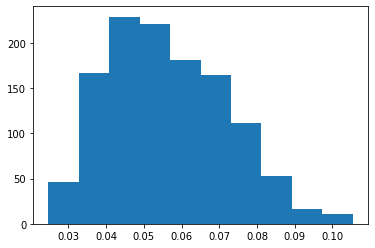

In [9]:
h = plt.hist( pdf['a_w'] )
t = plt.xlabel('Semi-Major  Width')

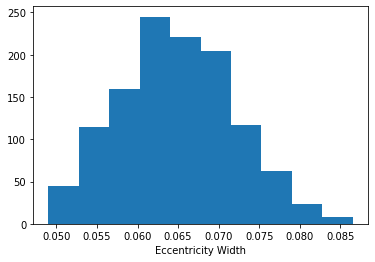

In [13]:
h = plt.hist( pdf['e_w'] )
t = plt.xlabel('Eccentricity Width')

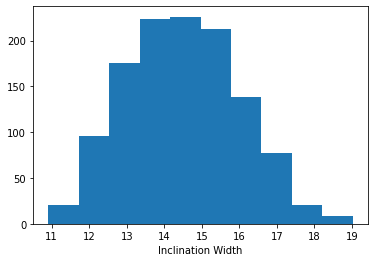

In [14]:
h = plt.hist( pdf['i_w'] )
t = plt.xlabel('Inclination Width')